In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

X_data = np.loadtxt('data/X.txt')
y_data = np.loadtxt('data/y.txt')

X_data, y_data = shuffle(X_data, y_data)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=800)

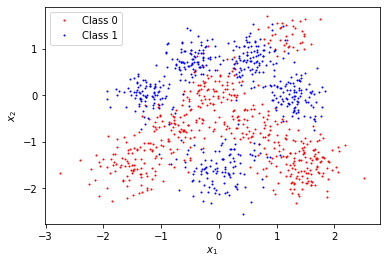

In [2]:
import matplotlib.pyplot as plt


def plot_classes(X, y, filename=None):
    figure = plt.figure()
    class0 = y == 0
    class1 = y == 1
    plt.plot(X[class0, 0], X[class0, 1], 'ro', markersize=1, label='Class 0')
    plt.plot(X[class1, 0], X[class1, 1], 'bo', markersize=1, label='Class 1')
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.legend(loc='upper left')
    if filename:
        plt.savefig(filename)
    return figure

plot_classes(X_data, y_data, "plots/data.png")
plt.show()

In [3]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

In [4]:
def prepend_ones(M):
    return np.column_stack((np.ones(M.shape[0]), M))

In [5]:
def mean_log_likelihood(w, X, y):
    X1 = prepend_ones(X)
    sigma = logistic(X1 @ w)
    return np.mean(y * np.log(sigma)
                   + (1 - y) * np.log(1 - sigma))

In [6]:
def gradient_ascent(training_inputs, training_outputs,
                    test_inputs, test_outputs,
                    number_iterations=100, learning_rate=1e-3):
    X1 = prepend_ones(training_inputs)
    X1_test = prepend_ones(test_inputs)
    w = np.zeros(X1.shape[1])
    L_train = np.empty(number_iterations)
    L_test = np.empty(number_iterations)
    for i in range(number_iterations):
        dL = (y_train - logistic(X1 @ w)) @ X1
        w += learning_rate * dL
        L_train[i] = mean_log_likelihood(w, training_inputs, training_outputs)
        L_test[i] = mean_log_likelihood(w, test_inputs, test_outputs)
    return w, L_train, L_test

In [7]:
w, L_train, L_test = gradient_ascent(X_train, y_train, X_test, y_test)
print(f"Final training LL: {L_train[-1]:.3f} \nFinal test LL:{L_test[-1]:.3f}")

Final training LL: -0.623 
Final test LL:-0.626


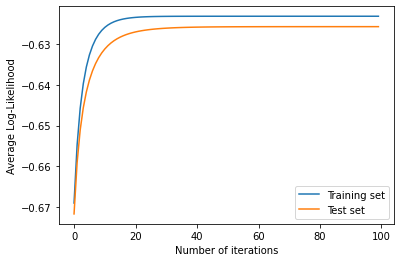

In [8]:
def plot_log_likelihood(L_train, L_test, filename=None):
    plt.figure()
    plt.plot(L_train, label='Training set')
    plt.plot(L_test, label='Test set')
    plt.xlabel('Number of iterations')
    plt.ylabel('Average Log-Likelihood')
    plt.legend()
    if filename:
        plt.savefig(filename)
    plt.show()

plot_log_likelihood(L_train, L_test, "plots/log_likelihood.png")

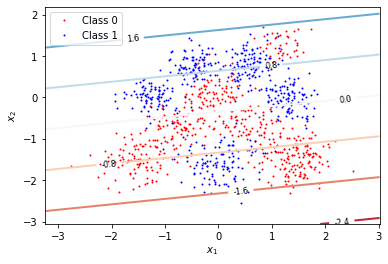

In [9]:
def plot_predictive_distribution(inputs, labels, weights, map_inputs = lambda x : x, filename=None):
    plot_classes(inputs, labels)
    x_min, x_max = inputs[ :, 0 ].min() - .5, inputs[ :, 0 ].max() + .5
    y_min, y_max = inputs[ :, 1 ].min() - .5, inputs[ :, 1 ].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    ax = plt.gca()
    X_tilde = prepend_ones(map_inputs(np.concatenate((xx.ravel().reshape((-1, 1)), yy.ravel().reshape((-1, 1))), 1)))
    Z = X_tilde @ weights
    Z = Z.reshape(xx.shape)
    cs2 = ax.contour(xx, yy, Z, cmap = 'RdBu', linewidths = 2)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize = 8)
    if filename:
        plt.savefig(filename)
    plt.show()
    
plot_predictive_distribution(X_data, y_data, w, filename="plots/predictive_distribution_linear.png")

In [10]:
def confusion_matrix(weights, test_data, test_labels):
    class_probabilities = logistic(prepend_ones(test_data) @ weights)
    predicted_class1 = class_probabilities <= 0.5
    predicted_class2 = class_probabilities > 0.5
    correctly_predicted_class1 = np.sum(np.logical_and(predicted_class1, test_labels == 0)) / np.sum(test_labels == 0)
    incorrectly_predicted_class1 = np.sum(np.logical_and(predicted_class1, test_labels == 1)) / np.sum(test_labels == 1)
    correctly_predicted_class2 = np.sum(np.logical_and(predicted_class2, test_labels == 1)) / np.sum(test_labels == 1)
    incorrectly_predicted_class2 = np.sum(np.logical_and(predicted_class2, test_labels == 0)) / np.sum(test_labels == 0)

    print(f"[[{correctly_predicted_class1:.3f}, {incorrectly_predicted_class2:.3f}],\n"
          f" [{incorrectly_predicted_class1:.3f}, {correctly_predicted_class2:.3f}]]")


In [11]:
print("Linear classifier confusion matrix:")
confusion_matrix(w, X_test, y_test)

Linear classifier confusion matrix:
[[0.729, 0.271],
 [0.298, 0.702]]


In [12]:
def evaluate_basis_functions(l, X, Z):
    X2 = np.sum(X**2, 1)
    Z2 = np.sum(Z**2, 1)
    ones_Z = np.ones(Z.shape[ 0 ])
    ones_X = np.ones(X.shape[ 0 ])
    r2 = np.outer(X2, ones_Z) - 2 * np.dot(X, Z.T) + np.outer(ones_X, Z2)
    return np.exp(-0.5 / l**2 * r2)

WIDTH=0.01
Final LL_train: -0.484
 Final LL_test: -0.688
Confusion matrix:
[[0.979, 0.021],
 [0.875, 0.125]]


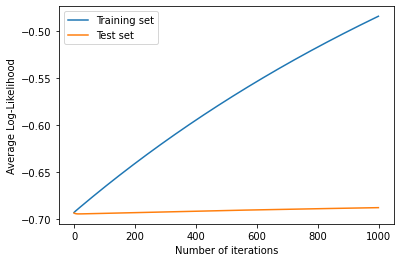

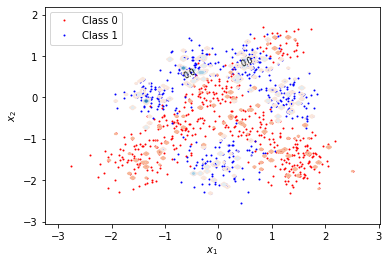

WIDTH=0.1
Final LL_train: -0.181
 Final LL_test: -0.265
Confusion matrix:
[[0.948, 0.052],
 [0.125, 0.875]]


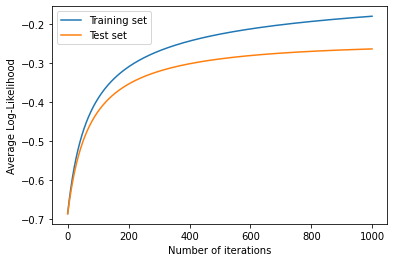

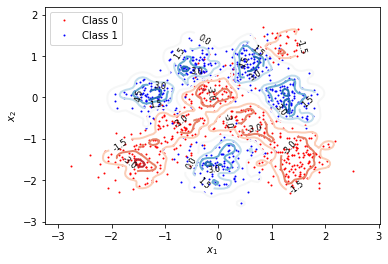

WIDTH=1
Final LL_train: -0.255
 Final LL_test: -0.230
Confusion matrix:
[[0.906, 0.094],
 [0.087, 0.913]]


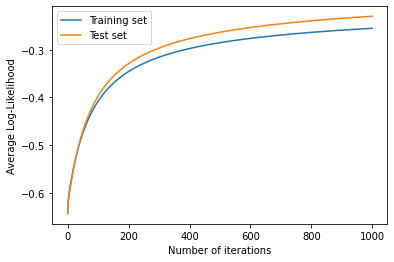

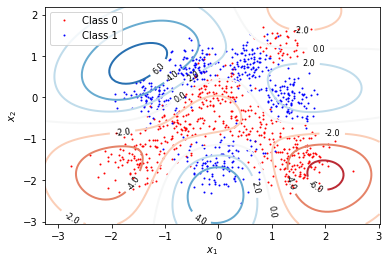

In [13]:
widths = [0.01, 0.1, 1]
learning_rates = [1e-3, 1e-3, 1e-4]

for width, learning_rate in zip(widths, learning_rates):
    X_train_rbf = evaluate_basis_functions(width, X_train, X_train)
    X_test_rbf = evaluate_basis_functions(width, X_test, X_train)
    w, L_train, L_test = gradient_ascent(X_train_rbf, y_train,
                                         X_test_rbf, y_test,
                                         number_iterations=1000,
                                         learning_rate=learning_rate)
    print(f"WIDTH={width}")
    print(f"Final LL_train: {L_train[-1]:.3f}\n Final LL_test: {L_test[-1]:.3f}")    
    print("Confusion matrix:")
    confusion_matrix(w, X_test_rbf, y_test)
    plot_log_likelihood(L_train, L_test)
    plot_predictive_distribution(X_data, y_data, w,
                                 lambda x: evaluate_basis_functions(width, x, X_train),
                                filename=f"plots/predictive_distribution_nonlinear_w={width}.png")
    